In [ ]:
# code github https://github.com/pytorch/examples/blob/main/fast_neural_style/neural_style/__init__.py
# kênh https://www.youtube.com/watch?v=M3lZNbFJ6I0&t=1s

import argparse
import os
import sys
import time
import re

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import torch.onnx
from PIL import Image
from collections import namedtuple
from tqdm import tqdm

# Kiểm tra xem có sử dụng GPU được không
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hàm chuyển đổi ảnh sang định dạng tensor
def image_loader(image_name, size=None):
    loader = transforms.Compose([
        transforms.Resize(size) if size is not None else transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def save_image_tensor(tensor, filename):
    # Chuyển tensor thành hình ảnh và lưu
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()  # Chuyển về CPU
    image = image.squeeze(0)      # Loại bỏ batch dimension
    image = unloader(image)
    image.save(filename)

dataset_path = '/path/to/your/dataset'  # Thư mục chứa ảnh để huấn luyện
style_image_path = '/path/to/your/style_image.jpg'  # Đường dẫn đến ảnh style
save_model_dir = '/path/to/save/model'  # Thư mục lưu model sau huấn luyện


class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out


class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out


def load_image(filename, size=None, scale=None):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img


def save_image(filename, data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    img.save(filename)


def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram


def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std


def check_paths(args):
    try:
        if not os.path.exists(args.save_model_dir):
            os.makedirs(args.save_model_dir)
        if args.checkpoint_model_dir is not None and not (os.path.exists(args.checkpoint_model_dir)):
            os.makedirs(args.checkpoint_model_dir)
    except OSError as e:
        print(e)
        sys.exit(1)


def train(args):
    if args.cuda:
        device = torch.device("cuda")
    elif args.mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    transform = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.CenterCrop(args.image_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    train_dataset = datasets.ImageFolder(args.dataset, transform)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size)

    transformer = TransformerNet().to(device)
    optimizer = Adam(transformer.parameters(), args.lr)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg16(requires_grad=False).to(device)
    style_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    style = load_image(args.style_image, size=args.style_size)
    style = style_transform(style)
    style = style.repeat(args.batch_size, 1, 1, 1).to(device)

    features_style = vgg(normalize_batch(style))
    gram_style = [gram_matrix(y) for y in features_style]

    for e in range(args.epochs):
        transformer.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()

            x = x.to(device)
            y = transformer(x)

            y = normalize_batch(y)
            x = normalize_batch(x)

            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = args.content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

            style_loss = 0.
            for ft_y, gm_s in zip(features_y, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
            style_loss *= args.style_weight

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item()

            if (batch_id + 1) % args.log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                  agg_content_loss / (batch_id + 1),
                                  agg_style_loss / (batch_id + 1),
                                  (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                print(mesg)

            if args.checkpoint_model_dir is not None and (batch_id + 1) % args.checkpoint_interval == 0:
                transformer.eval().cpu()
                ckpt_model_filename = "ckpt_epoch_" + str(e) + "_batch_id_" + str(batch_id + 1) + ".pth"
                ckpt_model_path = os.path.join(args.checkpoint_model_dir, ckpt_model_filename)
                torch.save(transformer.state_dict(), ckpt_model_path)
                transformer.to(device).train()

    # save model
    transformer.eval().cpu()
    save_model_filename = "epoch_" + str(args.epochs) + "_" + str(time.ctime()).replace(' ', '_') + "_" + str(
        args.content_weight) + "_" + str(args.style_weight) + ".model"
    save_model_path = os.path.join(args.save_model_dir, save_model_filename)
    torch.save(transformer.state_dict(), save_model_path)

    print("\nDone, trained model saved at", save_model_path)


def stylize(args):
    device = torch.device("cuda" if args.cuda else "cpu")

    content_image = load_image(args.content_image, scale=args.content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    if args.model.endswith(".onnx"):
        output = stylize_onnx(content_image, args)
    else:
        with torch.no_grad():
            style_model = TransformerNet()
            state_dict = torch.load(args.model)
            # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
            for k in list(state_dict.keys()):
                if re.search(r'in\d+\.running_(mean|var)$', k):
                    del state_dict[k]
            style_model.load_state_dict(state_dict)
            style_model.to(device)
            style_model.eval()
            if args.export_onnx:
                assert args.export_onnx.endswith(".onnx"), "Export model file should end with .onnx"
                output = torch.onnx._export(
                    style_model, content_image, args.export_onnx, opset_version=11,
                ).cpu()            
            else:
                output = style_model(content_image).cpu()
    save_image(args.output_image, output[0])


def stylize_onnx(content_image, args):
    """
    Read ONNX model and run it using onnxruntime
    """

    assert not args.export_onnx

    import onnxruntime

    ort_session = onnxruntime.InferenceSession(args.model)

    def to_numpy(tensor):
        return (
            tensor.detach().cpu().numpy()
            if tensor.requires_grad
            else tensor.cpu().numpy()
        )

    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(content_image)}
    ort_outs = ort_session.run(None, ort_inputs)
    img_out_y = ort_outs[0]

    return torch.from_numpy(img_out_y)


def main():
    main_arg_parser = argparse.ArgumentParser(description="parser for fast-neural-style")
    subparsers = main_arg_parser.add_subparsers(title="subcommands", dest="subcommand")

    train_arg_parser = subparsers.add_parser("train", help="parser for training arguments")
    train_arg_parser.add_argument("--epochs", type=int, default=2,
                                  help="number of training epochs, default is 2")
    train_arg_parser.add_argument("--batch-size", type=int, default=4,
                                  help="batch size for training, default is 4")
    train_arg_parser.add_argument("--dataset", type=str, required=True,
                                  help="path to training dataset, the path should point to a folder "
                                       "containing another folder with all the training images")
    train_arg_parser.add_argument("--style-image", type=str, default="images/style-images/mosaic.jpg",
                                  help="path to style-image")
    train_arg_parser.add_argument("--save-model-dir", type=str, required=True,
                                  help="path to folder where trained model will be saved.")
    train_arg_parser.add_argument("--checkpoint-model-dir", type=str, default=None,
                                  help="path to folder where checkpoints of trained models will be saved")
    train_arg_parser.add_argument("--image-size", type=int, default=256,
                                  help="size of training images, default is 256 X 256")
    train_arg_parser.add_argument("--style-size", type=int, default=None,
                                  help="size of style-image, default is the original size of style image")
    train_arg_parser.add_argument("--cuda", type=int, required=True,
                                  help="set it to 1 for running on GPU, 0 for CPU")
    train_arg_parser.add_argument("--seed", type=int, default=42,
                                  help="random seed for training")
    train_arg_parser.add_argument("--content-weight", type=float, default=1e5,
                                  help="weight for content-loss, default is 1e5")
    train_arg_parser.add_argument("--style-weight", type=float, default=1e10,
                                  help="weight for style-loss, default is 1e10")
    train_arg_parser.add_argument("--lr", type=float, default=1e-3,
                                  help="learning rate, default is 1e-3")
    train_arg_parser.add_argument("--log-interval", type=int, default=500,
                                  help="number of images after which the training loss is logged, default is 500")
    train_arg_parser.add_argument("--checkpoint-interval", type=int, default=2000,
                                  help="number of batches after which a checkpoint of the trained model will be created")

    eval_arg_parser = subparsers.add_parser("eval", help="parser for evaluation/stylizing arguments")
    eval_arg_parser.add_argument("--content-image", type=str, required=True,
                                 help="./Images/vangogh2photo/train/trainB")
    eval_arg_parser.add_argument("--content-scale", type=float, default=None,
                                 help="factor for scaling down the content image")
    eval_arg_parser.add_argument("--output-image", type=str, required=True,
                                 help="path for saving the output image")
    eval_arg_parser.add_argument("--model", type=str, required=True,
                                 help="saved model to be used for stylizing the image. If file ends in .pth - PyTorch path is used, if in .onnx - Caffe2 path")
    eval_arg_parser.add_argument("--cuda", type=int, default=False,
                                 help="0")
    eval_arg_parser.add_argument("--export_onnx", type=str,
                                 help="export ONNX model to a given file")
    eval_arg_parser.add_argument('--mps', action='store_true', default=False, help='enable macOS GPU training')

    args = main_arg_parser.parse_args()

    if args.subcommand is None:
        print("ERROR: specify either train or eval")
        sys.exit(1)
    if args.cuda and not torch.cuda.is_available():
        print("ERROR: cuda is not available, try running on CPU")
        sys.exit(1)
    if not args.mps and torch.backends.mps.is_available():
        print("WARNING: mps is available, run with --mps to enable macOS GPU")

    if args.subcommand == "train":
        check_paths(args)
        train(args)
    else:
        stylize(args)


if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

# Kiểm tra xem có sử dụng GPU được không
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hàm chuyển đổi ảnh sang định dạng tensor
def image_loader(image_name, size=None):
    loader = transforms.Compose([
        transforms.Resize(size) if size is not None else transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def save_image_tensor(tensor, filename):
    # Chuyển tensor thành hình ảnh và lưu
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()  # Chuyển về CPU
    image = image.squeeze(0)      # Loại bỏ batch dimension
    image = unloader(image)
    image.save(filename)

dataset_path = './Images/vangogh2photo/train/trainB'  # Thư mục chứa ảnh để huấn luyện
style_image_path = './Images/styled/style_image1.png'  # Đường dẫn đến ảnh style
save_model_dir = './saveModel'  # Thư mục lưu model sau huấn luyện

class TransformerNet(nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Kiến trúc đơn giản với Conv2d và các lớp Upsample
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))

        x = self.upsample1(x)
        x = torch.relu(self.conv4(x))
        x = self.upsample2(x)
        x = torch.relu(self.conv5(x))
        return torch.sigmoid(self.conv6(x))

def train(args):
    # Load dữ liệu style
    style_image = image_loader(args.style_image, size=args.style_size)
    
    # Load dataset
    transform = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.CenterCrop(args.image_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    train_dataset = datasets.ImageFolder(args.dataset, transform)
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

    # Mô hình và optimizer
    transformer = TransformerNet().to(device)
    optimizer = torch.optim.Adam(transformer.parameters(), args.lr)

    # Huấn luyện mô hình
    for epoch in range(args.epochs):
        transformer.train()
        for batch_id, (x, _) in enumerate(tqdm(train_loader)):
            x = x.to(device)
            optimizer.zero_grad()
            
            y = transformer(x)
            loss = torch.mean((y - x)**2)  # Example loss function
            
            loss.backward()
            optimizer.step()

            if (batch_id + 1) % args.log_interval == 0:
                print(f'Epoch [{epoch+1}/{args.epochs}], Batch [{batch_id+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Lưu mô hình sau mỗi epoch
        if args.checkpoint_model_dir:
            checkpoint_path = os.path.join(args.checkpoint_model_dir, f"checkpoint_epoch_{epoch+1}.pth")
            torch.save(transformer.state_dict(), checkpoint_path)
            print(f'Saved checkpoint: {checkpoint_path}')
    
    # Lưu mô hình sau khi huấn luyện hoàn thành
    model_save_path = os.path.join(args.save_model_dir, "style_transformer.pth")
    torch.save(transformer.state_dict(), model_save_path)
    print(f'Saved model: {model_save_path}')

class Args:
    epochs = 2  # Số lượng epochs huấn luyện
    batch_size = 4  # Kích thước batch
    dataset = dataset_path  # Đường dẫn dataset
    style_image = style_image_path  # Đường dẫn ảnh style
    save_model_dir = save_model_dir  # Thư mục lưu model
    checkpoint_model_dir = None  # Nếu muốn lưu checkpoint sau mỗi epoch
    image_size = 256  # Kích thước ảnh
    style_size = None  # Kích thước ảnh style (None để dùng kích thước gốc)
    content_weight = 1e5  # Trọng số ảnh nội dung
    style_weight = 1e10  # Trọng số ảnh style
    lr = 1e-3  # Learning rate
    log_interval = 500  # Interval log
    cuda = torch.cuda.is_available()  # Sử dụng GPU nếu có
    mps = False  # Để sử dụng GPU Apple M1 (nếu cần)

args = Args()

train(args)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import cv2
import os

# Hàm để tải và xử lý hình ảnh
def load_and_preprocess_image(path, target_size=(256, 256)):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    return img

# Xây dựng mô hình U-Net
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

# Huấn luyện mô hình
def train_unet_model(model, content_images, style_images, epochs=10, batch_size=16):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

    # Ensure content_images and style_images are the same length
    min_length = min(len(content_images), len(style_images))
    content_images = content_images[:min_length]
    style_images = style_images[:min_length]

    for epoch in range(epochs):
        for i in range(0, min_length, batch_size):
            batch_content = content_images[i:i + batch_size]
            batch_style = style_images[i:i + batch_size]

            # Huấn luyện trên batch
            loss = model.train_on_batch(batch_content, batch_style)
            print(f"Epoch: {epoch + 1}, Batch: {i // batch_size + 1}, Loss: {loss:.4f}")

# Áp dụng chuyển đổi phong cách
def apply_style_transfer(model, input_image):
    input_image = np.expand_dims(input_image, axis=0)  # Thêm chiều batch
    output_image = model.predict(input_image)
    return output_image[0]  # Trả về hình ảnh đầu ra

# Hàm chính để chạy
def main(content_dir, style_dir, epochs=10):
    # Đường dẫn đến các hình ảnh nội dung và phong cách
    content_images = [load_and_preprocess_image(os.path.join(content_dir, f)) for f in os.listdir(content_dir)]
    style_images = [load_and_preprocess_image(os.path.join(style_dir, f)) for f in os.listdir(style_dir)]

    # Định nghĩa mô hình
    input_shape = (256, 256, 3)
    model = unet_model(input_shape)

    # Huấn luyện mô hình
    train_unet_model(model, np.array(content_images), np.array(style_images), epochs)

    # Lưu mô hình
    model.save('unet_style_transfer_model.keras')

    # Áp dụng chuyển đổi phong cách cho một hình ảnh ví dụ
    test_image = load_and_preprocess_image(os.path.join(content_dir, os.listdir(content_dir)[0]))
    output_image = apply_style_transfer(model, test_image)

    # Hiển thị hình ảnh đầu ra
    output_image = (output_image * 255).astype(np.uint8)
    cv2.imshow("Output", output_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Chạy chương trình chính
if __name__ == "__main__":
    main('./Images/Monet2Photo/testB', './Images/Monet2Photo/testA', epochs=1)


Epoch: 1, Batch: 1, Loss: 0.0447
Epoch: 1, Batch: 2, Loss: 0.0482
Epoch: 1, Batch: 3, Loss: 0.0459
Epoch: 1, Batch: 4, Loss: 0.0489
Epoch: 1, Batch: 5, Loss: 0.0501
Epoch: 1, Batch: 6, Loss: 0.0493
Epoch: 1, Batch: 7, Loss: 0.0495
Epoch: 1, Batch: 8, Loss: 0.0489


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [ ]:
import matplotlib.pyplot as plt

def show_image(img, title=''):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()
content_dir = './Images/Monet2Photo/testB'
# Kiểm tra ảnh đầu vào
test_image = load_and_preprocess_image(os.path.join(content_dir, os.listdir(content_dir)[0]))
show_image(test_image, 'Input Image')


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Function to load and process images
def load_and_process_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (512, 512))  # Output image size
    img = img[tf.newaxis, :]  # Add batch dimension
    return img

# Function to display images
def display_image(image):
    image = np.squeeze(image, axis=0)  # Remove batch dimension
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Load content and style images
content_image = load_and_process_image('./Images/color/5.jpg')  # Change path
style_image = load_and_process_image('./style_image.png')  # Change path

# Create VGG19 model for feature extraction
vgg = keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Choose layers for content and style extraction
content_layers = ['block5_conv2']  # Content layer
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

# Function to get features from VGG19
def get_model():
    outputs = [vgg.get_layer(name).output for name in (style_layers + content_layers)]
    model = keras.Model(inputs=vgg.input, outputs=outputs)
    return model

# Function to calculate Gram matrix
def gram_matrix(tensor):
    temp = tf.squeeze(tensor)  # Remove batch dimension
    channels = int(temp.shape[-1])
    a = tf.reshape(temp, [-1, channels])
    gram = tf.matmul(tf.transpose(a), a)
    return gram

# Function to calculate content and style features
def get_features(model, content, style):
    outputs = model(tf.concat([content, style], axis=0))  # Process both images together
    content_outputs = outputs[len(style_layers):]
    style_outputs = outputs[:len(style_layers)]

    # Debug print to check lengths and shapes
    print(f"Content Outputs Length: {len(content_outputs)}")  # Should be 1
    print(f"Style Outputs Length: {len(style_outputs)}")      # Should match len(style_layers)

    style_features = [gram_matrix(style_output) for style_output in style_outputs]

    # Ensure the lengths are consistent
    if len(style_features) != len(style_layers):
        raise ValueError(f"Expected {len(style_layers)} style features but got {len(style_features)}")

    return style_features, content_outputs

# Function to compute loss
def compute_loss(style_features, content_features, generated_image):
    generated_outputs = model(generated_image)

    # Debug print to check lengths
    print(f"Generated Outputs Length: {len(generated_outputs)}")  # Should match len(style_layers) + 1
    generated_content_features = generated_outputs[len(style_layers):]

    # Check lengths before proceeding
    if len(content_features) == 0 or len(generated_content_features) == 0:
        raise ValueError("Content features length is zero, check the model output.")

    # Content loss
    content_loss = tf.reduce_mean(tf.square(content_features[0] - generated_content_features[0]))

    # Style loss
    generated_style_features = generated_outputs[:len(style_layers)]

    style_loss = tf.add_n([
        tf.reduce_mean(tf.square(style_feature - gram_matrix(generated_style_features[i])))
        for i, style_feature in enumerate(style_features)
    ])
    style_loss *= 1.0 / len(style_layers)

    total_loss = content_loss + style_loss
    return total_loss

# Optimize generated image
def train_step(model, generated_image, style_features, content_features, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(style_features, content_features, generated_image)
    gradients = tape.gradient(loss, generated_image)
    optimizer.apply_gradients([(gradients, generated_image)])
    return loss

# Run style transfer process
def style_transfer(content_image, style_image):
    global model
    model = get_model()
    style_features, content_features = get_features(model, content_image, style_image)

    generated_image = tf.Variable(content_image)  # Initialize generated image
    optimizer = keras.optimizers.Adam(learning_rate=0.02)

    epochs = 1000  # Number of iterations
    for i in range(epochs):
        loss = train_step(model, generated_image, style_features, content_features, optimizer)
        if i % 100 == 0:
            print(f'Epoch {i}, Loss: {loss.numpy()}')
            display_image(generated_image)

    return generated_image

# Execute style transfer
result_image = style_transfer(content_image, style_image)
display_image(result_image)


Start of iteration 0
Loss at iteration 0: 6.665084704488419e+22
Start of iteration 1
Loss at iteration 1: 2.6595368088289378e+22
Start of iteration 2
Loss at iteration 2: 1.6076170827051662e+22
Start of iteration 3
Loss at iteration 3: 1.503127716670655e+22
Start of iteration 4
Loss at iteration 4: 9.665641282861254e+21
Start of iteration 5
Loss at iteration 5: 7.288501787946658e+21
Start of iteration 6
Loss at iteration 6: 5.275500840903103e+21
Start of iteration 7
Loss at iteration 7: 4.6166222450939627e+21
Start of iteration 8
Loss at iteration 8: 4.2815752619658744e+21
Start of iteration 9
Loss at iteration 9: 3.969326907526419e+21


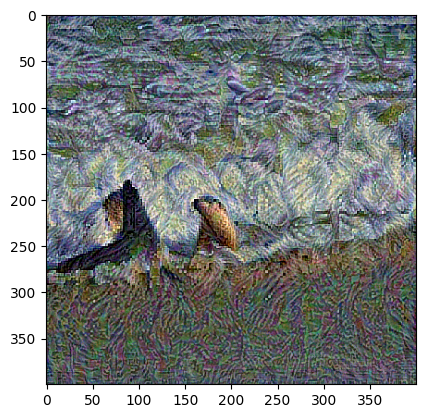

In [2]:
# code ok

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg19
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b

# Paths to style and content images
StylePath = './'
ContentPath = './Images/color/'

base_image_path = ContentPath + '13.jpg'
style_image_path = StylePath + 'style_image1.png'

# Image dimensions
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# Function to preprocess images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# Function to deprocess the image after generation
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Reverse VGG19 preprocessing
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Preprocess base and style images
base_image = tf.Variable(preprocess_image(base_image_path), dtype=tf.float32)
style_reference_image = tf.Variable(preprocess_image(style_image_path), dtype=tf.float32)
combination_image = tf.Variable(preprocess_image(base_image_path), dtype=tf.float32)

# Load VGG19 model without the top layers and pre-trained on ImageNet
vgg = vgg19.VGG19(weights='imagenet', include_top=False)
output_layers = [vgg.get_layer(name).output for name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']]
model = tf.keras.Model(inputs=vgg.input, outputs=output_layers)

# Function to calculate content loss
def get_content_loss(base_content, target):
    return tf.reduce_sum(tf.square(target - base_content))

# Function to calculate gram matrix for style loss
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram

# Function to calculate style loss
def get_style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    return tf.reduce_sum(tf.square(S - C))

# Combine content and style loss
content_weight = 0.025
style_weight = 1.0

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = model(input_tensor)
    
    # Content loss
    base_image_features = features[4][0, :, :, :]
    combination_features = features[4][2, :, :, :]
    content_loss = content_weight * get_content_loss(base_image_features, combination_features)
    
    # Style loss
    style_loss = 0
    for i in range(5):
        style_features = features[i][1, :, :, :]
        combination_style_features = features[i][2, :, :, :]
        style_loss += get_style_loss(style_features, combination_style_features) / 5
    
    total_loss = content_loss + (style_weight * style_loss)
    return total_loss

# Function to compute gradients
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

# Optimize the image
evaluator = None
iterations = 10
best_loss, best_img = float('inf'), None
optimizer = tf.optimizers.Adam(learning_rate=10.0)

for i in range(iterations):
    print(f'Start of iteration {i}')
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])
    print(f'Loss at iteration {i}: {loss}')

    if loss < best_loss:
        best_loss = loss
        best_img = combination_image.numpy()

# Display the result
imgx = deprocess_image(best_img)
plt.imshow(imgx)
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b

# Preprocessing functions
def preprocess_image_instantiator(image_path, img_nrows, img_ncols):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# Loss functions
def get_content_loss(base_content, target):
    return tf.reduce_sum(tf.square(base_content - target))

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def get_style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# Deprocessing image
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # Convert 'BGR' -> 'RGB'
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Run the style transfer
def Run_StyleTransfer(base_image_path, style_image_path):
    width, height = load_img(base_image_path).size
    global img_nrows, img_ncols
    img_nrows = 400
    img_ncols = int(width * img_nrows / height)

    base_image = tf.Variable(preprocess_image_instantiator(base_image_path, img_nrows, img_ncols), dtype=tf.float32)
    style_reference_image = tf.Variable(preprocess_image_instantiator(style_image_path, img_nrows, img_ncols), dtype=tf.float32)
    combination_image = tf.Variable(preprocess_image_instantiator(base_image_path, img_nrows, img_ncols), dtype=tf.float32)

    model = vgg19.VGG19(include_top=False, weights='imagenet')
    outputs_dict = {layer.name: layer.output for layer in model.layers}
    
    # Content loss
    content_weight = 0.025
    style_weight = 1.0
    loss = tf.Variable(0.0)

    layer_features = outputs_dict['block5_conv2']
    base_image_features = layer_features[0]
    combination_features = layer_features[2]
    loss = loss + content_weight * get_content_loss(base_image_features, combination_features)

    # Style loss
    feature_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1]
        combination_features = layer_features[2]
        sl = get_style_loss(style_reference_features, combination_features)
        loss = loss + (style_weight / len(feature_layers)) * sl

    grads = tf.gradients(loss, combination_image)[0]

    optimizer = tf.optimizers.Adam(learning_rate=0.01)

    @tf.function
    def train_step():
        with tf.GradientTape() as tape:
            loss_value = loss
        grads = tape.gradient(loss_value, combination_image)
        optimizer.apply_gradients([(grads, combination_image)])
        return loss_value

    # Run the optimization
    iterations = 200
    best_loss, best_img = float('inf'), None
    for i in range(iterations):
        loss_value = train_step()
        if loss_value < best_loss:
            best_loss = loss_value
            best_img = combination_image.numpy()

    imgx = deprocess_image(best_img)
    return imgx

# Paths to the images
base_image_path_1 = '../input/image-classification/images/images/travel and  adventure/Places365_val_00005821.jpg'
style_image_path_1 = '../input/best-artworks-of-all-time/images/images/Paul_Klee/Paul_Klee_96.jpg'

# Displaying images
plt.figure(figsize=(30, 30))
plt.subplot(5, 5, 1)
plt.title("Base Image", fontsize=20)
img_base = load_img(base_image_path_1)
plt.imshow(img_base)

plt.subplot(5, 5, 2)
plt.title("Style Image", fontsize=20)
img_style = load_img(style_image_path_1)
plt.imshow(img_style)

plt.subplot(5, 5, 3)
imgg = Run_StyleTransfer(base_image_path_1, style_image_path_1)
plt.title("Final Image", fontsize=20)
plt.imshow(imgg)


In [27]:
import tensorflow as tf
from tensorflow import keras

# Hàm lưu mô hình trích xuất đặc trưng với nhiều layer hơn cho phong cách
def save_feature_extractor_model():
    vgg = keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    # Chọn thêm các layer để trích xuất đặc trưng phong cách
    style_layers = [
        'block1_conv1', 'block1_conv2',
        'block2_conv1', 'block2_conv2',
        'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4',
        'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4',
        'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4'
    ]
    content_layers = ['block5_conv2']  # Content layers không thay đổi

    # Kết hợp các layer thành một model
    outputs = [vgg.get_layer(name).output for name in (style_layers + content_layers)]
    feature_model = keras.Model(inputs=vgg.input, outputs=outputs)

    # Lưu model trích xuất đặc trưng
    feature_model.save("vgg19_feature_model.keras")  # Lưu với định dạng HDF5

# Lưu mô hình với các layer mới một lần
save_feature_extractor_model()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0, Loss: 1163294408704.0


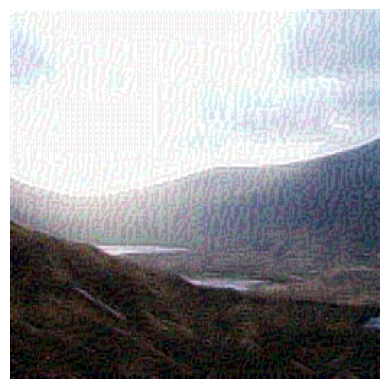

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1, Loss: 1135313551360.0


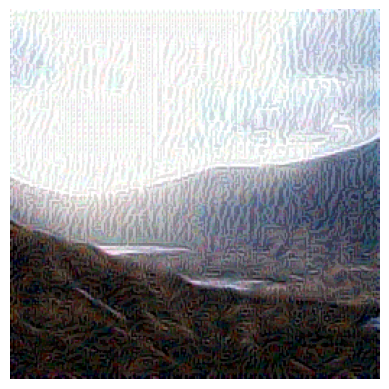

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2, Loss: 910455799808.0


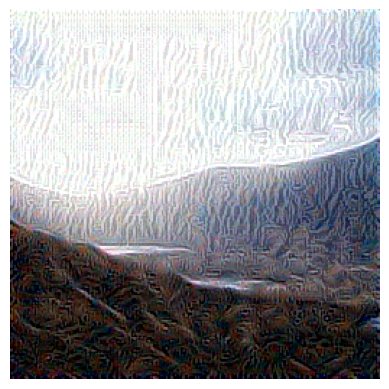

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3, Loss: 797061349376.0


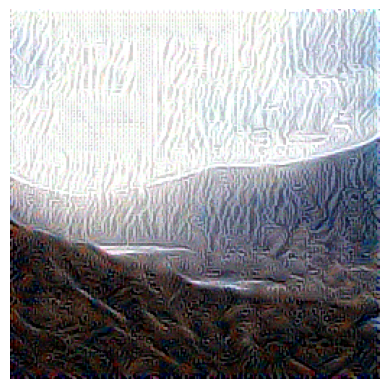

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4, Loss: 722541740032.0


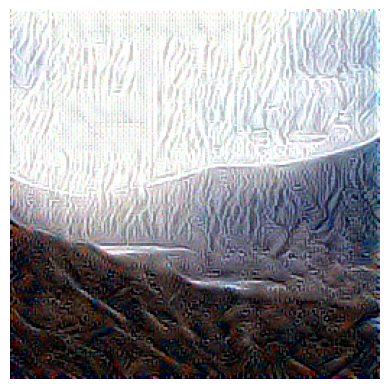

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5, Loss: 661132673024.0


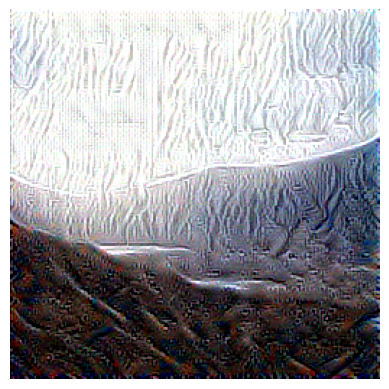

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6, Loss: 608193413120.0


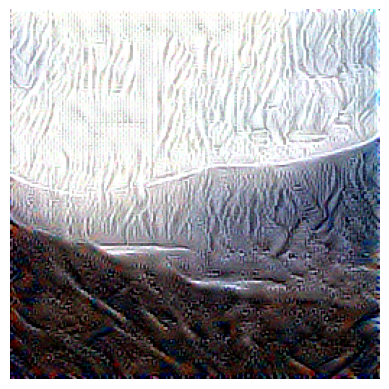

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7, Loss: 560311828480.0


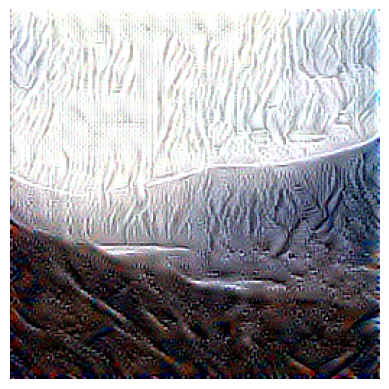

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 8, Loss: 518450741248.0


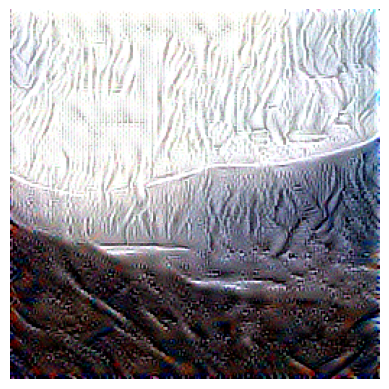

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9, Loss: 481899118592.0


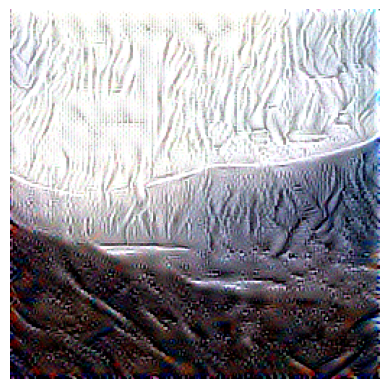

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


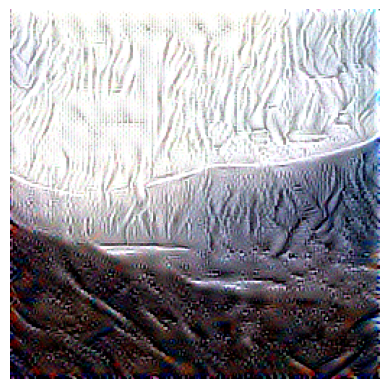

: 

In [20]:
# code ok

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import os

# Hàm load và xử lý ảnh
def load_and_process_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (256, 256))  # Reduced size
    img = img[tf.newaxis, :]  # Add batch dimension
    return img

# Hàm hiển thị ảnh
def display_image(image):
    image = np.squeeze(image, axis=0)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Hàm tính ma trận Gram cho ảnh phong cách
def gram_matrix(tensor):
    temp = tf.squeeze(tensor)
    channels = int(temp.shape[-1])
    a = tf.reshape(temp, [-1, channels])
    gram = tf.matmul(tf.transpose(a), a)
    return gram

# Load the feature extractor model with an additional output for content
def load_feature_extractor_model():
    base_model = keras.applications.VGG19(include_top=False, weights='imagenet')
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_layer = 'block5_conv4'  # Content layer to extract features from
    outputs = [base_model.get_layer(name).output for name in style_layers] + [base_model.get_layer(content_layer).output]
    return keras.models.Model(inputs=base_model.input, outputs=outputs)

# Adjusting feature extraction logic
def extract_features(model, content_image, style_image):
    outputs = model(tf.concat([content_image, style_image], axis=0))
    
    # Separate style and content outputs
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    style_outputs = outputs[:len(style_layers)]
    content_outputs = outputs[len(style_layers):]  # Last output will be content features

    # Check if outputs are not empty
    if len(content_outputs) == 0:
        raise ValueError("No content features extracted.")
    
    # Calculate Gram matrices for style features
    style_features = [gram_matrix(style_output) for style_output in style_outputs]
    
    return style_features, content_outputs


# Hàm tính toán loss
def compute_loss(style_features, content_features, generated_image, model):
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    generated_outputs = model(generated_image)
    
    # Ensure generated outputs have content features
    generated_content_features = generated_outputs[len(style_layers):]

    # Check if content features exist
    if not content_features or not generated_content_features:
        raise ValueError("Content features are missing.")

    # Content loss
    content_loss = tf.reduce_mean(tf.square(content_features[0] - generated_content_features[0]))

    # Style loss
    generated_style_features = generated_outputs[:len(style_layers)]
    style_loss = tf.add_n([
        tf.reduce_mean(tf.square(style_feature - gram_matrix(generated_style_features[i])))
        for i, style_feature in enumerate(style_features)
    ])
    style_loss *= 1.0 / len(style_layers)

    alpha = 1.0  # Weight for content loss
    beta = 100.0  # Weight for style loss
    total_loss = alpha * content_loss + beta * style_loss

    return total_loss

# Modify the apply_new_style function
def apply_new_style(content_image, new_style_image, patience=3, model_save_path='style_transfer_model'):
    model = load_feature_extractor_model()
    style_features, content_features = extract_features(model, content_image, new_style_image)
    
    generated_image = tf.Variable(content_image)
    
    optimizer = keras.optimizers.Adam(learning_rate=0.05)

    epochs = 10
    best_loss = float('inf')
    early_stop_counter = 0

    for i in range(epochs):
        loss = train_step(model, generated_image, style_features, content_features, optimizer)

        
        print(f'Epoch {i}, Loss: {loss.numpy()}')
        display_image(generated_image)

        if loss < best_loss:
            best_loss = loss
            early_stop_counter = 0
            model.save(model_save_path + '.keras')  
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f'Stopping early at epoch {i} with best loss {best_loss.numpy()}')
                break

    return generated_image


# Tải và xử lý ảnh
content_image = load_and_process_image('./Images/color/26.jpg')  # Change path to content image
new_style_image = load_and_process_image('./style_image2.png')   # Change path to style image

# Execute style transfer with Early Stopping
result_image = apply_new_style(content_image, new_style_image, patience=10)
display_image(result_image)

Step 0, Loss: 146805152.0
Step 10, Loss: 11436834.0
Step 20, Loss: 4691972.0
Step 30, Loss: 2800900.0
Step 40, Loss: 1951304.0
Step 50, Loss: 1557227.75
Step 60, Loss: 1335369.25
Step 70, Loss: 1190752.625
Step 80, Loss: 1083213.75
Step 90, Loss: 997522.625
Step 100, Loss: 926398.125
Step 110, Loss: 865324.4375
Step 120, Loss: 811809.0
Step 130, Loss: 764081.9375
Step 140, Loss: 720996.0625
Step 150, Loss: 681933.0
Step 160, Loss: 646216.3125
Step 170, Loss: 613313.25
Step 180, Loss: 582766.625
Step 190, Loss: 554314.75
Step 200, Loss: 527759.375
Step 210, Loss: 502914.09375
Step 220, Loss: 479617.96875
Step 230, Loss: 457699.09375
Step 240, Loss: 437020.65625
Step 250, Loss: 417495.40625
Step 260, Loss: 399046.40625
Step 270, Loss: 381581.71875
Step 280, Loss: 365031.53125
Step 290, Loss: 349314.65625
Step 300, Loss: 334364.96875
Step 310, Loss: 320141.4375
Step 320, Loss: 306615.03125
Step 330, Loss: 293753.96875
Step 340, Loss: 281510.0
Step 350, Loss: 269864.46875
Step 360, Loss: 2

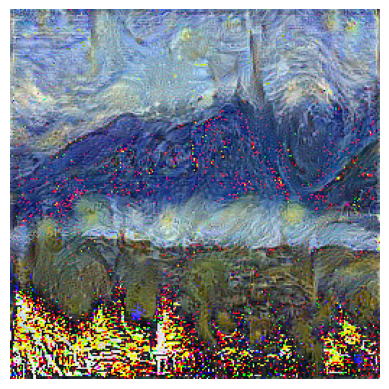

In [18]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Model

# Helper functions
def load_and_process_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, (256, 256))  # Resize to 256x256
    img = img[tf.newaxis, :] / 255.0  # Add batch dimension and normalize to [0, 1]
    return img

class StyleTransferModel(Model):
    def __init__(self, content_weight=1e3, style_weight=1e-2):
        super(StyleTransferModel, self).__init__()
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.vgg = VGG19(include_top=False, weights='imagenet')
        self.vgg.trainable = False

        # Define content and style layers
        self.content_layers = ['block5_conv2']
        self.style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
        
        self.outputs = [self.vgg.get_layer(name).output for name in self.content_layers + self.style_layers]
        self.feature_model = Model(inputs=self.vgg.input, outputs=self.outputs)

    def call(self, inputs):
        return self.feature_model(inputs)

    def total_loss(self, outputs, content_target, style_targets):
        content_output, *style_outputs = outputs
        
        c_loss = self.content_loss(content_output, content_target)
        s_loss = sum(self.style_loss(style_output, style_target) for style_output, style_target in zip(style_outputs, style_targets))
        
        return self.content_weight * c_loss + self.style_weight * s_loss

    def content_loss(self, base_content, target):
        return tf.reduce_mean(tf.square(base_content - target))

    def gram_matrix(self, tensor):
        channels = int(tensor.shape[-1])
        a = tf.reshape(tensor, [-1, channels])
        return tf.matmul(a, a, transpose_a=True)

    def style_loss(self, base_style, target):
        return tf.reduce_mean(tf.square(self.gram_matrix(base_style) - self.gram_matrix(target)))

# Load content and style images
content_image_path = './Images/color/7.jpg'
style_image_path = './style_image1.png'

content_image = load_and_process_image(content_image_path)
style_image = load_and_process_image(style_image_path)

# Initialize model and extract features
style_transfer_model = StyleTransferModel()
content_target = style_transfer_model(content_image)[0]
style_targets = style_transfer_model(style_image)[1:]

# Initialize generated image as a copy of the content image
generated_image = tf.Variable(content_image, dtype=tf.float32)

# Define optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.02)

# Training loop
for step in range(1000):  # Increased number of steps
    with tf.GradientTape() as tape:
        outputs = style_transfer_model(generated_image)
        loss = style_transfer_model.total_loss(outputs, content_target, style_targets)

    gradients = tape.gradient(loss, [generated_image])
    optimizer.apply_gradients(zip(gradients, [generated_image]))
    
    if step % 10 == 0:  # Print every 10 steps
        print(f"Step {step}, Loss: {loss.numpy()}")

# Save the trained model
style_transfer_model.save('style_transfer_model1.keras')

# Visualize the generated image
generated_image_np = np.squeeze(generated_image.numpy()) * 255
generated_image_np = generated_image_np.astype(np.uint8)

plt.imshow(generated_image_np)
plt.axis('off')
plt.show()

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Model

class StyleTransferModel(Model):
    def __init__(self, content_weight=1e3, style_weight=1e-2):
        super(StyleTransferModel, self).__init__()
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.vgg = VGG19(include_top=False, weights='imagenet')
        self.vgg.trainable = False

        # Define content and style layers
        self.content_layers = ['block5_conv2']
        self.style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
        
        self.outputs = [self.vgg.get_layer(name).output for name in self.content_layers + self.style_layers]
        self.feature_model = Model(inputs=self.vgg.input, outputs=self.outputs)

    def call(self, inputs):
        return self.feature_model(inputs)

    def total_loss(self, outputs, content_target, style_targets):
        content_output, *style_outputs = outputs
        c_loss = self.content_loss(content_output, content_target)
        s_loss = sum(self.style_loss(style_output, style_target) for style_output, style_target in zip(style_outputs, style_targets))
        return self.content_weight * c_loss + self.style_weight * s_loss

    def content_loss(self, base_content, target):
        return tf.reduce_mean(tf.square(base_content - target))

    def gram_matrix(self, tensor):
        channels = int(tensor.shape[-1])
        a = tf.reshape(tensor, [-1, channels])
        return tf.matmul(a, a, transpose_a=True)

    def style_loss(self, base_style, target):
        return tf.reduce_mean(tf.square(self.gram_matrix(base_style) - self.gram_matrix(target)))

    def get_config(self):
        config = super(StyleTransferModel, self).get_config()
        config.update({
            'content_weight': self.content_weight,
            'style_weight': self.style_weight,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Load the model with custom_objects
loaded_model = tf.keras.models.load_model('style_transfer_model1.keras', custom_objects={'StyleTransferModel': StyleTransferModel})


# Sử dụng mô hình với ảnh mới
new_content_image = load_and_process_image('./Images/color/8.jpg')
new_style_image = load_and_process_image('./Images/styled/style_image1.png')

content_target_new = loaded_model(new_content_image)[0]
style_targets_new = loaded_model(new_style_image)[1:]

# Khởi tạo ảnh sinh mới
new_generated_image = tf.Variable(new_content_image, dtype=tf.float32)

# Hàm hiển thị ảnh
def display_image(image):
    if image.ndim == 2:
        image = np.repeat(image[np.newaxis, ...], 1, axis=0)
    elif image.ndim == 3:
        image = np.expand_dims(image, axis=0)
    
    image = np.clip(image[0], 0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Hiển thị ảnh sinh mới
display_image(new_generated_image)


TypeError: <class '__main__.StyleTransferModel'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'StyleTransferModel', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'StyleTransferModel', 'build_config': {'input_shape': [1, 256, 256, 3]}}.

Exception encountered: StyleTransferModel.__init__() got an unexpected keyword argument 'trainable'

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

def build_model():
    inputs = layers.Input(shape=(None, None, 3))  # Hình ảnh đầu vào

    # Lớp tích chập
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Sử dụng Global Average Pooling để giảm kích thước
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(3)(x)  # Đầu ra với 3 kênh màu RGB

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Tạo mô hình
style_transfer_model = build_model()

def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (256, 256))
    img = img[tf.newaxis, :]  # Thêm chiều batch
    return img

def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

def gram_matrix(tensor):
    # Chuyển đổi tensor thành ma trận Gram
    channels = int(tensor.shape[-1])
    a = tf.reshape(tensor, [-1, channels])
    gram = tf.matmul(tf.transpose(a), a)
    return gram

def style_loss(base_style, target):
    return tf.reduce_mean(tf.square(gram_matrix(base_style) - gram_matrix(target)))

# Đường dẫn đến hình ảnh nội dung và phong cách
content_image = load_and_preprocess_image('./Images/color/7.jpg')
style_image = load_and_preprocess_image('./style_image1.png')

# Huấn luyện mô hình
optimizer = tf.optimizers.Adam(learning_rate=0.01)
num_iterations = 100

for i in range(num_iterations):
    with tf.GradientTape() as tape:
        generated_image = style_transfer_model(content_image)  # Tạo hình ảnh mới
        
        # Tính toán mất mát
        c_loss = content_loss(content_image, generated_image)
        s_loss = style_loss(style_image, generated_image)
        total_loss = c_loss + 1e-4 * s_loss  # Tùy chỉnh hệ số cho mất mát phong cách
    
    # Tính gradient và cập nhật trọng số
    grads = tape.gradient(total_loss, style_transfer_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, style_transfer_model.trainable_variables))
    
    if i % 100 == 0:
        print(f'Iteration: {i}, Total loss: {total_loss.numpy()}')

# Lưu mô hình
style_transfer_model.save('style_transfer_model1.keras')


Iteration: 0, Total loss: 12108.7041015625


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def load_and_preprocess_image(image_path, target_size=(256, 256)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Load the saved model
loaded_model = tf.keras.models.load_model('style_transfer_model1.keras')

# Apply the model to a new image
new_content_image = load_and_preprocess_image('./Images/color/7.jpg')
stylized_image = loaded_model(new_content_image)

# Convert tensor to numpy array and check shape
stylized_image = stylized_image.numpy()
print("Shape of stylized_image:", stylized_image.shape)

# Display the stylized image
def display_image(image):
    if image.ndim == 2:
        image = np.repeat(image[np.newaxis, ...], 1, axis=0)
    elif image.ndim == 3:
        image = np.expand_dims(image, axis=0)
    
    image = np.clip(image[0], 0, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

display_image(stylized_image)


TypeError: Could not locate class 'StyleTransferModel'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'StyleTransferModel', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'StyleTransferModel', 'build_config': {'input_shape': [1, 256, 256, 3]}}